In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Evrişimli Sinir Ağları (CNN) ile Katı Atık Tespiti

Katı atık sınıflandırma problemi
Atık ayırt etmek için gerekli altyapıyı hazırlıyoruz

## Veriyi Anlamak (Data Understanding)

Veri Seti Hikayesi 

Bu proje kapsamında kullanacağımız veri seti TrashNet isimli veri setidir. 
Stanford Universitesi öğrencileri tarafından hazırlanılmıştır.

Veri seti altı farklı sınıftan oluşmaktadır.

Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır.

Görüntülerin dağılımı

• 501 cam

• 594 kağıt 

• 403 karton 

• 482 plastik

• 410 metal

• 137 çöp

Görüntüler, beyaz bir panoya yerleştirilerek ve güneş ışığı veya oda aydınlatması kullanılarak çekilmiştir. Görüntüler, 512 x 384 piksel boyutlarında ve 3 (RGB) kanallidir.

Veri setini indirmek için Kaggle sayfasini ziyaret edebilirsiniz.
https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

In [ ]:
# Veri okuma, model değerlenedirme ve model için gerekli kütüphanelerin kurulması.

In [ ]:
!pip install imutils
import cv2
import urllib
import itertools 
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob 
from imutils import paths
import matplotlib.pyplot as plt 
from sklearn.utils import shuffle 
from urllib.request import urlopen
import warnings 
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dir_path="/content/drive/MyDrive/Garbage classification"

In [ ]:
# target size and label

In [ ]:
target_size=(224,224)

In [ ]:
waste_labels = {"cardboard":0,"glass":1,"metal":2,"paper":3,"plastic":4,"trash":5}

In [ ]:
def load_datasets(path):
  x = []
  labels = []
  image_paths = sorted(list(paths.list_images(path))) 

  for image_path in image_paths:

    img = cv2.imread(image_path)

    img= cv2.resize(img, target_size)

    x.append(img)

    label = image_path.split(os.path.sep)[-2]

    labels.append(waste_labels[label])

  x, labels = shuffle(x, labels, random_state = 42)

  print(f"X boyutu: {np.array(x).shape}")
  print(f"Label Sınıf Sayısı: {len(np.unique(labels))} Gözlem Sayısı: {len(labels)}")

  return x, labels

In [ ]:
x, labels = load_datasets(dir_path)

X boyutu: (2528, 224, 224, 3)
Label Sınıf Sayısı: 6 Gözlem Sayısı: 2528


In [ ]:
input_shape = (np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)

In [ ]:
print(input_shape)

(224, 224, 3)


In [ ]:
def visualize_img(image_batch,label_batch):
  plt.figure(figsize=(10,10))
  for n in range(10):
    ax=plt.subplot(5,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(np.array(list(waste_labels.keys()))[to_categorical(labels, num_classes=6)[n]==1][0].title())
    plt.axis("off")

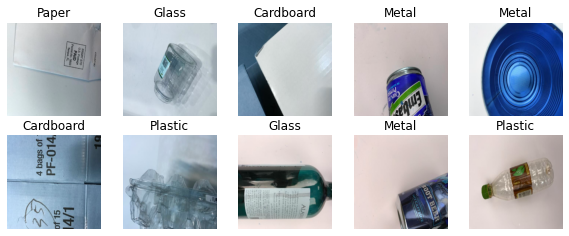

In [ ]:
visualize_img(x, labels)

In [ ]:
# data preparation

In [ ]:
train = ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)

test = ImageDataGenerator(rescale=1/255,
                          validation_split=0.1)

In [ ]:
?ImageDataGenerator

In [ ]:
train_generator=train.flow_from_directory(directory=dir_path,
                                          target_size=(target_size),
                                          class_mode="categorical",
                                          subset="training")

test_generator=test.flow_from_directory(directory=dir_path,
                                        target_size=(target_size),
                                        batch_size=251,
                                        class_mode="categorical",
                                        subset="validation")

Found 2277 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


## Modelleme (Modeling)
Sıfırdan CNN Modeli Kurma

• Sequential

• Evrişim Katmani (Convolution Layer, Conv2D) 

• Havuzlama Katmanı (Pooling Layer) 

• Aktivasyon Fonksiyonu Katmani (Activation Layer)

• Flattening Katmani

• Dense Katmanı

• Dropout Katmani


In [ ]:
model=Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same",input_shape=(input_shape),activation="relu"))
model.add(MaxPooling2D(pool_size=2,strides=(2,2)))

model.add(Flatten())

model.add(Dense(units=64,activation="relu"))

model.add(Dropout(rate=0.2))

model.add(Dense(units=23,activation="relu"))

model.add(Dropout(rate=0.2))

model.add(Dense(units=6,activation="softmax"))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

In [ ]:
# Optimizasyon ve Değerlenirme Metriklerin Ayarlanması

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer="adam",
              metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),"acc" ])
# categorical_crossentropy 2 den fazla oldugu icin 2 olsa binary olurdu
# adam gibi bircok farklı deneme yanılma yoluyla yapılabilir
# metrik kendimiz seceriz

In [ ]:
callbacks = [EarlyStopping(monitor="val_loss",patience=50,verbose=1,mode="min"),
             ModelCheckpoint(filepath="mymodel.h5",monitor="val_loss",mode="min",save_best_only=True,save_weights_only=False,verbose=1)]
             

In [ ]:
# Modelin Eğitilmesi

In [ ]:
history = model.fit_generator(generator=train_generator,
                              epochs=100,
                              validation_data=test_generator,
                              callbacks=callbacks,
                              workers=4,
                              steps_per_epoch=2277//32,
                              validation_steps=251//32)

Epoch 1/100
71/71 [==============================] - ETA: 0s - loss: 1.7750 - precision: 0.1379 - recall: 0.0018 - acc: 0.2241
Epoch 1: val_loss improved from inf to 1.69327, saving model to mymodel.h5
71/71 [==============================] - 42s 456ms/step - loss: 1.7750 - precision: 0.1379 - recall: 0.0018 - acc: 0.2241 - val_loss: 1.6933 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.2869
Epoch 2/100
71/71 [==============================] - ETA: 0s - loss: 1.6858 - precision: 0.5921 - recall: 0.0200 - acc: 0.2579
Epoch 2: val_loss improved from 1.69327 to 1.57702, saving model to mymodel.h5
71/71 [==============================] - 33s 446ms/step - loss: 1.6858 - precision: 0.5921 - recall: 0.0200 - acc: 0.2579 - val_loss: 1.5770 - val_precision: 0.8333 - val_recall: 0.0398 - val_acc: 0.3147
Epoch 3/100
71/71 [==============================] - ETA: 0s - loss: 1.5201 - precision: 0.7163 - recall: 0.0922 - acc: 0.3541
Epoch 3: val_loss improved from 1.57702 to 1.5215

In [ ]:
# loss az olması lazım  teknik olarak hatamızı azaltırız
# acc recall ve precision %73 gibi
# epoch arttırılıp daha iyi yapılabilir.

In [ ]:
# acc ve loss grafikleri

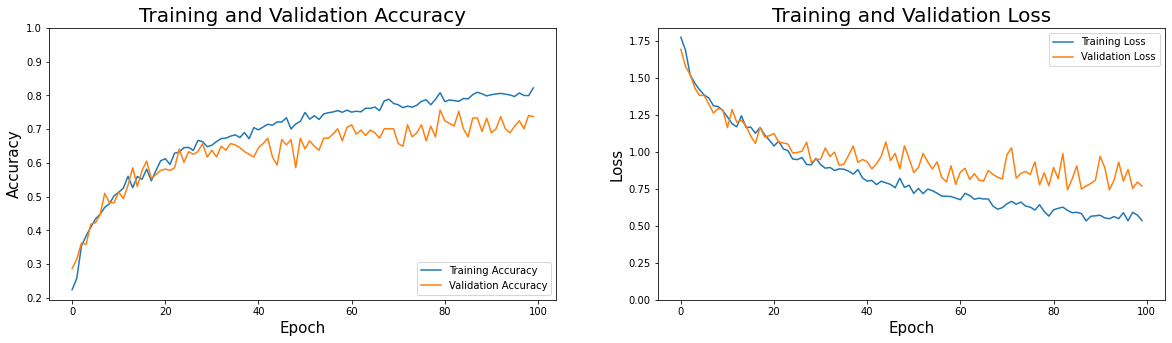

In [ ]:
# acc
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(history.history["acc"],label="Training Accuracy")
plt.plot(history.history["val_acc"],label="Validation Accuracy")
plt.legend(loc="lower right")
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy",fontsize=20)

# loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=20)
plt.show()

In [ ]:
# Evaluation

In [ ]:
loss,precision,recall,acc=model.evaluate(test_generator,batch_size=32)

1/1 [==============================] - 1s 1s/step - loss: 0.7688 - precision: 0.7944 - recall: 0.6773 - acc: 0.7371


In [ ]:
print("Test Acc %.1f%%" % (100.0*acc))
print("Test Loss %.1f%%" % (100.0*loss))
print("Test precision %.1f%%" % (100.0*precision))
print("Test recall %.1f%%" % (100.0*recall))

Test Acc 73.7%
Test Loss 76.9%
Test precision 79.4%
Test recall 67.7%


In [ ]:
# Classification report

x_test, y_test=test_generator.next()
y_pred=model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
y_test=np.argmax(y_test,axis=1)

8/8 [==============================] - 0s 26ms/step


In [ ]:
target_names=list(waste_labels.keys())

In [ ]:
print(classification_report(y_test,y_pred,target_names=target_names))

              precision    recall  f1-score   support

   cardboard       0.96      0.68      0.79        40
       glass       0.69      0.72      0.71        50
       metal       0.62      0.78      0.69        41
       paper       0.81      0.98      0.89        59
     plastic       0.71      0.52      0.60        48
       trash       0.58      0.54      0.56        13

    accuracy                           0.74       251
   macro avg       0.73      0.70      0.71       251
weighted avg       0.75      0.74      0.73       251



In [ ]:
# gercek degerlere odaklanır recall
# tahmin degerinin isabetini bulur precision
# f1-score iki degerin harmonik ort

In [ ]:
# Confusion Matrix

cm = confusion_matrix(y_test,y_pred)

def plot_confusion_matrix(cm,classes,nomralize=False,title="Confusion matrix",cmap=plt.cm.Blues):
  if nomralize:
    cm=cm.astype("float")/cm.sum(axis=1)[:,np.newaxis]

  plt.figure(figsize=(8,6))
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  fmt=".2f" if nomralize else "d"
  thresh=cm.max()/2.
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             horizontalalignment="center",
             color="white" if cm[i,j]>thresh else "black")
    plt.tight_layout()
    plt.ylabel("True Label", fontweight="bold")
    plt.xlabel("Predicted Label", fontweight="bold")

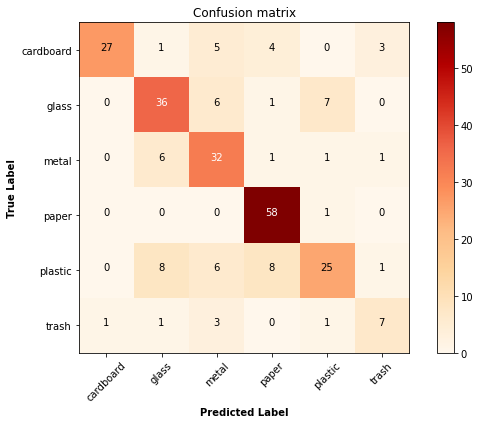

In [ ]:
plot_confusion_matrix(cm,
                      waste_labels.keys(),
                      title="Confusion matrix",
                      cmap=plt.cm.OrRd)

In [ ]:
# Model Test ve Kullanımı

In [ ]:
waste_labels={0:"cardboard",1:"glass",2:"metal",3:"paper",4:"plastic",5:"trash"}

1/1 [==============================] - 0s 15ms/step


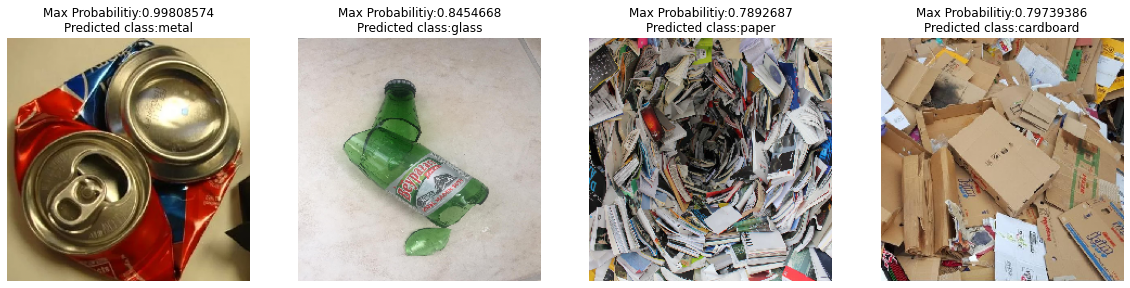

In [ ]:
def model_testing(path):

  img =image.load_img(path,target_size=(target_size))
  img =image.img_to_array(img,dtype=np.uint8)
  img=np.array(img)/255.0
  p=model.predict(img.reshape(1,224,224,3))
  predicted_class=np.argmax(p[0])

  return img,p,predicted_class

img1,p1,predicted_class1=model_testing("/content/drive/MyDrive/Garbage classification/metal.jpg")
img2,p2,predicted_class2=model_testing("/content/drive/MyDrive/Garbage classification/glass.jpg")
img3,p3,predicted_class3=model_testing("/content/drive/MyDrive/Garbage classification/kagit.jpg")
img4,p4,predicted_class4=model_testing("/content/drive/MyDrive/Garbage classification/karton.jpg")

plt.figure(figsize=(20,60))

plt.subplot(141)
plt.axis("off")
plt.imshow(img1.squeeze())
plt.title("Max Probabilitiy:"+ str(np.max(p1[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class1]))
plt.imshow(img1);

plt.subplot(142)
plt.axis("off")
plt.imshow(img2.squeeze())
plt.title("Max Probabilitiy:"+ str(np.max(p2[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class2]))
plt.imshow(img2);

plt.subplot(143)
plt.axis("off")
plt.imshow(img3.squeeze())
plt.title("Max Probabilitiy:"+ str(np.max(p3[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class3]))
plt.imshow(img3);

plt.subplot(144)
plt.axis("off")
plt.imshow(img4.squeeze())
plt.title("Max Probabilitiy:"+ str(np.max(p4[0],axis=-1))+"\n"+"Predicted class:"+str(waste_labels[predicted_class4]))
plt.imshow(img4);